# _ARIEL_

## Introduction

This notebook's aim is to display empirical evidences to justify the choices we made when we devised the model. We display a few tests who helped us create the model and verify that it was relevant to solve our problem.

In [1]:
from model_encoder import *
from optim_draw import *
import urllib.request 

# Asserting the model's coherence

### Blurring lines in order to simplify the optimization

CNNs treat the information locally, the problem is that if we only deal with extremely thin straight lines, if the line we are drawing is not initially extremely close to the target line we are trying to draw then we won't be able to optimize the parameters of the drawn line. Indeed outside of a very small sphere of pixels around the reference line, being 10 pixels or 60 pixels away from the target line doesn't make any difference from the point of view of the CNN's comparison loss. Since the gradient of the comparison loss will be zero, we won't be able to move step by step the drawn line closer to the target line by using a gradient descent.

This is why we decided to draw wider lines and to add a decay parameter so that each drawn line actually affects several pixels around it and is less restrictively localized.

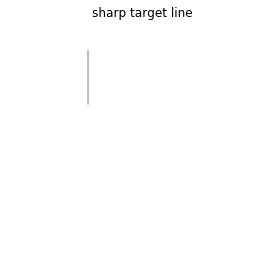

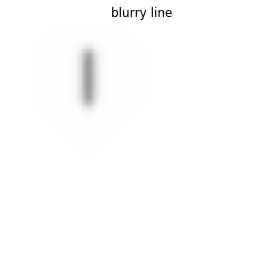

In [9]:
from model_benchmark import *

target_image = get_1line_image(32, 16, 32, 48, sharp=True)
blurry_image = get_1line_image(32, 16, 32, 48, sharp=False)

cnn = CNNFeatureExtractor()
for param in cnn.model.parameters():  # the cnn feature extractor has already been trained, we freeze its parameters
    param.requires_grad = False
cnn.add_comparison_loss(target_image)

losses_without_blurryness = []
losses_with_blurryness = []
for k in range(30):
    sharp_drawing = get_1line_image(32 + k, 16, 32 + k, 48, sharp=True)
    losses_without_blurryness.append(cnn.comparison_loss(cnn.model(sharp_drawing)))
    blurry_drawing = get_1line_image(32 + k, 16, 32 + k, 48, sharp=False)
    losses_with_blurryness.append(cnn.comparison_loss(cnn.model(blurry_drawing)))
    

imshow(target_image, title="sharp target line")
imshow(blurry_image, title="blurry line")

You can see above the 'sharp' target line to which we are going to compare each drawn line. Below it is displayed the kind of lines we draw.

With the following cell we show the impact of blurrying lines on the ability of the CNN to detect when the drawn line is close to its target. We see that the gradient is different than zero for a larger area in terms of pixels than we don't use the blurrying trick.

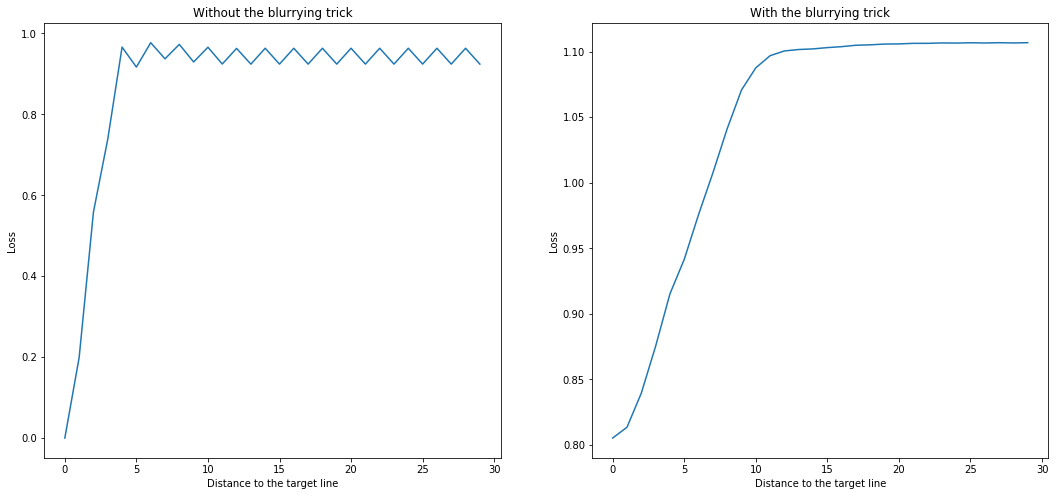

In [3]:
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(losses_without_blurryness)), losses_without_blurryness)
plt.xlabel("Distance to the target line")
plt.ylabel("Loss")
plt.title("Without the blurrying trick")
plt.subplot(1, 2, 2)
plt.plot(np.arange(len(losses_with_blurryness)), losses_with_blurryness)
plt.xlabel("Distance to the target line")
plt.ylabel("Loss")
plt.title("With the blurrying trick")
plt.show()

We show here using the simple example where the target image is just a single line that when we use the blurrying trick, the optimization of the coordinates of the line we draw works perfectly.

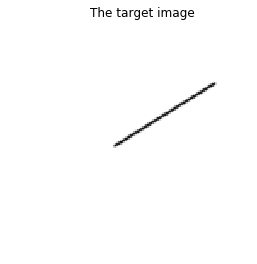

Drawing line number 0
Initializing the line..
Current best line initialization loss:  8.077680587768555
Current best line initialization loss:  7.867937088012695
Current best line initialization loss:  7.846579551696777
Current best line initialization loss:  7.576077461242676


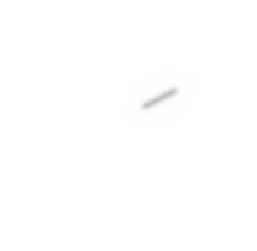

  2%|▏         | 1/50 [00:00<00:07,  6.83it/s]

Optimizing the line..


100%|██████████| 50/50 [00:08<00:00,  6.14it/s]


Final loss :  4.53675651550293


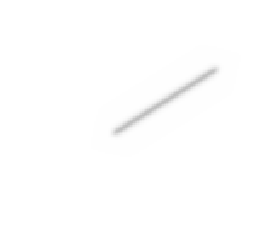

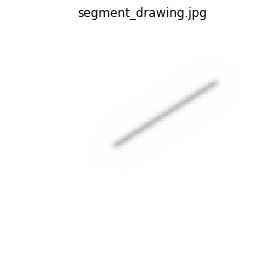

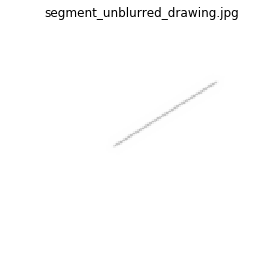

Complete runtime: 0h 0m 19s


In [10]:
imshow(image_loader("./Images/segment.jpg"), title="The target image")
n_epochs = 50
drawer = run(image_loader("./Images/segment.jpg"), 1, n_epochs, unblur=True, save=False, save_title='segment')

We display here the comparison loss between the target image and the unfinished drawing at every step of the optimization. We see that the blurrying trick allows the gradient descent to converge. We also observe that initializing randomly and selecting the best initialization is not enough in order to draw the target image, the optimization step of the drawing is also necessary since it allows to considerably reduce the comparison loss between the target image and the drawing.

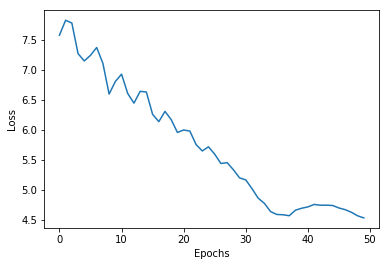

In [11]:
history = drawer.loss_history
plt.figure()
plt.plot(np.arange(n_epochs), history[:n_epochs])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()